# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import os
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Visualizations will be shown in the notebook.
%matplotlib inline
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import csv
import cv2
import PIL

---
## Step 0: Load The Data

In [2]:
# Create a path to the folder containing training data:
cwd  = os.getcwd()
path = '{}/{}'.format(cwd, 'traffic-signs-data')

# Load pickled data
training_file   = '{}/{}'.format(path, 'train.p')
validation_file = '{}/{}'.format(path, 'valid.p')
testing_file    = '{}/{}'.format(path, 'test.p')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_original, y_train = train['features'], train['labels']
X_valid_original, y_valid = valid['features'], valid['labels']
X_test_original, y_test = test['features'], test['labels']

X_train = np.copy(X_train_original)
X_valid = np.copy(X_valid_original)
X_test = np.copy(X_test_original)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = train.get('features').shape[0]

# TODO: Number of validation examples
n_valid = valid.get('features').shape[0]

# TODO: Number of testing examples.
n_test = test.get('features').shape[0]

# TODO: What's the shape of a traffic sign image?
image_shape = test.get('features').shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
num_unique_train = len(np.unique(train.get('labels')))
num_unique_valid = len(np.unique(valid.get('labels')))
num_unique_test  = len(np.unique(test.get('labels')))
n_classes = max(num_unique_train, num_unique_valid, num_unique_test)

# How many images of each class are there?
unique, counts = np.unique(y_train, return_counts=True)

print("Number of images in the training set   =", n_train)
print("Number of images in the validation set =", n_valid)
print("Number of images in the test set       =", n_test)
print("Image data shape                       =", image_shape)
print("Number of classes                      =", n_classes)

Number of images in the training set   = 34799
Number of images in the validation set = 4410
Number of images in the test set       = 12630
Image data shape                       = (32, 32, 3)
Number of classes                      = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

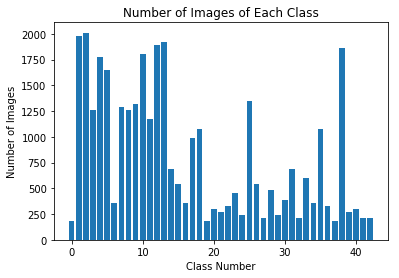

In [4]:
# Show images per class in bar chart:
plt.bar(unique, counts)
plt.title('Number of Images of Each Class')
plt.xlabel('Class Number')
plt.ylabel('Number of Images')
plt.show()

## Visualize Data

View a sample from the dataset.


In [5]:
def csv2dict():
    reader = csv.reader(open('signnames.csv'))
    dictionary = {}
    for row in reader:
        key = row[0]
        if key in dictionary:
            pass
        dictionary[key] = row[1:]
    #print(dictionary)
    return dictionary

def show_image_stats(img):
    print(f'Image Type  = {img.dtype}')
    print(f'Image Shape = {np.shape(img)}')
    print(f'Min  Pixel  = {round(np.min(img), 3)}')
    print(f'Mean Pixel  = {round(np.mean(img), 3)}')
    print(f'Max  Pixel  = {round(np.max(img), 3)}')
    
def show_random_image(X_train, y_train):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap="gray")
    key = str(y_train[index])
    print(f'Sign  Name  = {sign_names.get(key)[0]}')
    show_image_stats(X_train[index])
    return index

sign_names = csv2dict()

Sign  Name  = Speed limit (30km/h)
Image Type  = uint8
Image Shape = (32, 32, 3)
Min  Pixel  = 17
Mean Pixel  = 51.758
Max  Pixel  = 129


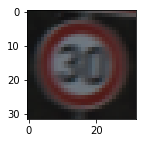

In [6]:
# Show a random image from the training set.  
# (...make sure that the Sign Name matches the image shown.)

index = show_random_image(X_train, y_train)

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

In [8]:
# Convert to grayscale
X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_valid_gray = np.sum(X_valid/3, axis=3, keepdims=True)
X_test_gray = np.sum(X_test/3, axis=3, keepdims=True)

X_train = X_train_gray
X_valid = X_valid_gray
X_test = X_test_gray
show_image_stats(X_train[index])

Image Type  = float64
Image Shape = (32, 32, 1)
Min  Pixel  = 17.333
Mean Pixel  = 51.758
Max  Pixel  = 120.333


In [9]:
# Normalize the datasets to approximately (-1,1):
X_train_normalized = ((X_train - 128)/128)
X_valid_normalized = ((X_valid - 128)/128)
X_test_normalized = ((X_test - 128)/128)

X_train = X_train_normalized 
X_valid = X_valid_normalized
X_test = X_test_normalized
show_image_stats(X_train[index])

Image Type  = float64
Image Shape = (32, 32, 1)
Min  Pixel  = -0.865
Mean Pixel  = -0.596
Max  Pixel  = -0.06


In [10]:
# Shuffle the datasets:
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)
show_image_stats(X_train[index])

Image Type  = float64
Image Shape = (32, 32, 1)
Min  Pixel  = -0.646
Mean Pixel  = -0.567
Max  Pixel  = -0.471


### Model Architecture

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [12]:
EPOCHS = 100
BATCH_SIZE = 128

In [13]:
# Unaltered from: LeNet-Lab-Solution.ipynb
# Gray:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [14]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [15]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.748

EPOCH 2 ...
Validation Accuracy = 0.825

EPOCH 3 ...
Validation Accuracy = 0.855

EPOCH 4 ...
Validation Accuracy = 0.854

EPOCH 5 ...
Validation Accuracy = 0.883

EPOCH 6 ...
Validation Accuracy = 0.862

EPOCH 7 ...
Validation Accuracy = 0.892

EPOCH 8 ...
Validation Accuracy = 0.876

EPOCH 9 ...
Validation Accuracy = 0.882

EPOCH 10 ...
Validation Accuracy = 0.897

EPOCH 11 ...
Validation Accuracy = 0.908

EPOCH 12 ...
Validation Accuracy = 0.900

EPOCH 13 ...
Validation Accuracy = 0.902

EPOCH 14 ...
Validation Accuracy = 0.895

EPOCH 15 ...
Validation Accuracy = 0.905

EPOCH 16 ...
Validation Accuracy = 0.907

EPOCH 17 ...
Validation Accuracy = 0.916

EPOCH 18 ...
Validation Accuracy = 0.912

EPOCH 19 ...
Validation Accuracy = 0.901

EPOCH 20 ...
Validation Accuracy = 0.909

EPOCH 21 ...
Validation Accuracy = 0.907

EPOCH 22 ...
Validation Accuracy = 0.908

EPOCH 23 ...
Validation Accuracy = 0.917

EPOCH 24 ...
Validation Accura

In [18]:
print("Validation Accuracy = {:.3f}".format(validation_accuracy))

Validation Accuracy = 0.938


In [19]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.927


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [20]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
# Create a path to the folder containing training data:

In [21]:
def resize_images(input_folder_name='additional-traffic-signs-data', width=32, height=32):
    output_folder_name = input_folder_name+'-resized'
    cwd  = os.getcwd()
    path = '{}/{}'.format(cwd, input_folder_name)
    
    if not os.path.exists('{}/{}'.format(cwd, output_folder_name)):
        os.mkdir('{}/{}'.format(cwd, output_folder_name))
    image_names = os.listdir(path)
       
    for i in range(len(image_names)):
        image = PIL.Image.open(path+'/'+image_names[i])        
        new_image = image.resize((width, height))
        new_image.save(output_folder_name+'/'+image_names[i])

In [22]:
resize_images()

In [23]:
def load_images_from_folder(input_folder_name='additional-traffic-signs-data-resized'):   
    original_image_names = os.listdir(input_folder_name)
    original_images = ['']*len(os.listdir(input_folder_name))
    for i in range(len(original_images)):
        original_images[i] = mpimg.imread(input_folder_name +'/'+ os.listdir(input_folder_name)[i])        
    return original_images, original_image_names

In [24]:
web_images, web_image_names = load_images_from_folder()

In [25]:
def list_to_array(images, image_names):
    num_images = len(images)
    width = web_images[0].shape[0]
    height = web_images[0].shape[1]
    channels = web_images[0].shape[2]    
    
    X_web = np.empty((num_images, width, height, channels), dtype='uint8')
    y_web = np.empty((num_images), dtype='uint8')
        
    for i in range(0, num_images):
        X_web[i] = images[i]
        y_web[i] = image_names[i].split('.')[0]
    
    return X_web, y_web

In [26]:
X_web_original, y_web_original = list_to_array(web_images, web_image_names)
X_web = np.copy(X_web_original)
y_web = np.copy(y_web_original)
# print(type(X_web))
# print(X_web.shape)
# plt.imshow(X_web[0])

In [27]:
# Preprocess web images:

# Grayscale
X_web_gray = np.sum(X_web/3, axis=3, keepdims=True)
X_web = X_web_gray

# Normalize
X_web_normalized = ((X_web - 128)/128)
X_web = X_web_normalized 

# Shuffle
X_web, y_web = shuffle(X_web, y_web)

### Predict the Sign Type for Each Image

In [28]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [29]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_web, y_web)   

INFO:tensorflow:Restoring parameters from ./lenet


### Analyze Performance

In [30]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [31]:
num_images = int(X_web.shape[0])
num_correct = int(round(test_accuracy, 2)*num_images)
num_incorrect = num_images - num_correct
test_accuracy_percentage = round(test_accuracy*100, 2)


print(f'The classifier correctly classified {num_correct} of {num_images} web images correctly.')
print(f'Test Accuracy = {test_accuracy_percentage}%')

The classifier correctly classified 4 of 5 web images correctly.
Test Accuracy = 80.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [32]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [33]:
TOP_K = 5
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=TOP_K), feed_dict={x:X_web})

INFO:tensorflow:Restoring parameters from ./lenet


In [34]:
def show_softmax(image_num, X_web, y_web, sign_names):
    
    # Get data:
    i = image_num
    image = X_web[i].squeeze()
    num_images = X_web.shape[0]
    correct_class_id  = str(y_web[i])
    title = sign_names[correct_class_id]
    softmax_class_ids = top[1][i].astype(str)       
    key_names = [None]*X_web.shape[0]
    for j in range(num_images):
        key_names[j] = sign_names[str(softmax_class_ids[j])][0]

    # Show the image with the correct class ID above it: 
    plt.figure(1)
    plt.subplot(221)
    plt.title(title)
    plt.imshow(image, cmap='gray')

    # Show softmax probabilities:
    plt.subplot(222)
    plt.bar(key_names, top[0][i]*100)
    plt.title('Softmax Probabilities')
    # plt.xlabel('')
    plt.ylabel('Probability (%)')
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=1.0, left=0.1, right=2.0, top=2.0)

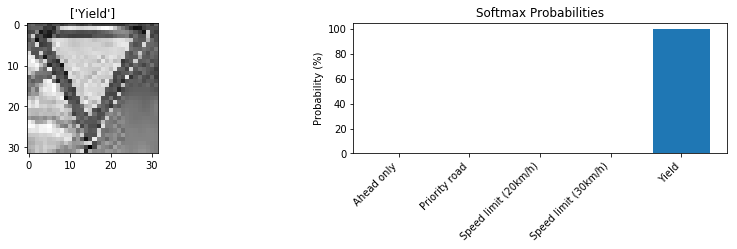

In [35]:
show_softmax(0, X_web, y_web, sign_names)

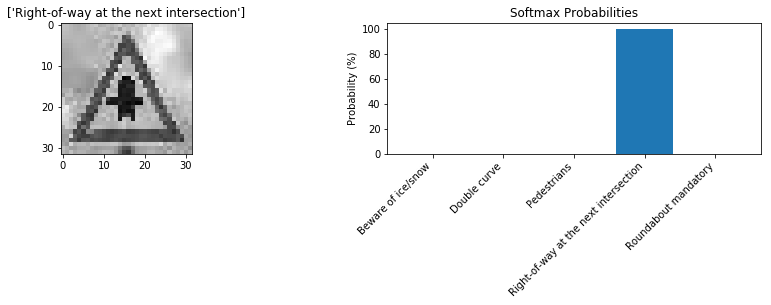

In [36]:
show_softmax(1, X_web, y_web, sign_names)

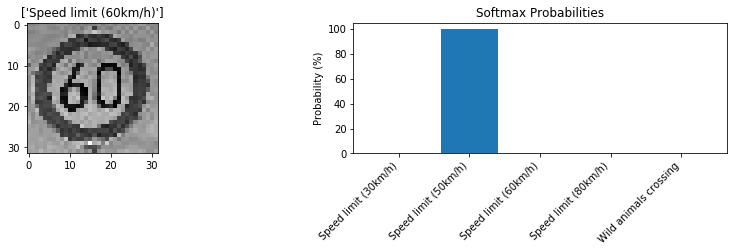

In [37]:
show_softmax(2, X_web, y_web, sign_names)

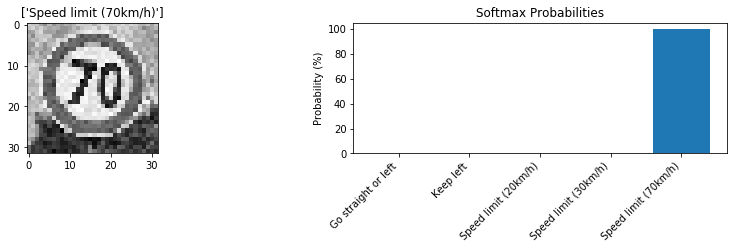

In [38]:
show_softmax(3, X_web, y_web, sign_names)

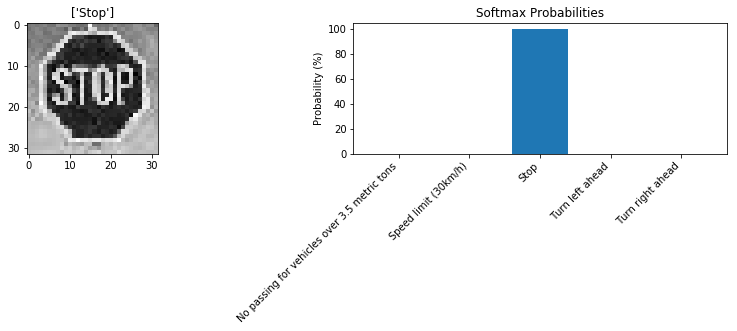

In [39]:
show_softmax(4, X_web, y_web, sign_names)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.